# Setup

In [ ]:
!nvidia-smi

Wed Jul 14 10:14:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/commaai/comma10k.git
!pip install segmentation_models_pytorch

Cloning into 'comma10k'...
remote: Enumerating objects: 61747, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 61747 (delta 1), reused 2 (delta 0), pack-reused 61740
Receiving objects: 100% (61747/61747), 7.47 GiB | 34.39 MiB/s, done.
Resolving deltas: 100% (8138/8138), done.
Checking out files: 100% (20600/20600), done.
     |████████████████████████████████| 92kB 7.0MB/s 
     |████████████████████████████████| 378kB 15.1MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=602e691e8a54a044cc6a895312e4523d9af1fe21c6bfd90bc7602e2d6f23133f
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=2671369bca04afa9cf90a4cfe8255657e858c51449f807acd1e3315c9e

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import cv2 
from glob import glob
import os
from tqdm.notebook import tqdm
import numpy as np


from random import randint
import matplotlib.pyplot as plt

# cv2.imshow() could crush
# from google.colab.patches import cv2_imshow

In [ ]:
# os.listdir("/content/comma10k/imgs")

In [ ]:
len(os.listdir("/content/comma10k/imgs"))

9888

In [ ]:
len(os.listdir("/content/comma10k/imgs2"))

400

In [ ]:
len(os.listdir("/content/comma10k/masks"))

9888

In [ ]:
len(os.listdir("/content/comma10k/masks2"))

400

In [ ]:
imgs_path = "/content/comma10k/imgs"
masks_path = "/content/comma10k/masks"
imgs_path_val = "/content/comma10k/imgs2"
masks_path_val = "/content/comma10k/masks2"


image_size = 256

device = 'cuda' if torch.cuda.is_available else 'cpu'

batch_size = 16
epochs = 10
num_workers = 2

# Dataset

In [ ]:
class SegmentationDataset:
  def __init__(self, imgs_path, masks_path, transform=None):
    self.imgs_path = sorted(glob(f"{imgs_path}/*.png"))[:16]
    self.masks_path = sorted(glob(f"{masks_path}/*.png"))[:16]
    self.transform = transform

  def __len__(self):
    assert len(self.imgs_path) == len(self.masks_path)   
    return len(self.imgs_path)

  def __getitem__(self, idx):

    img = cv2.imread(self.imgs_path[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # read in grayscale add 0
    mask = cv2.imread(self.masks_path[idx], 0)

    if self.transform:
      norm_img = transforms.Normalize((0.485,0.456,0.406),(0.229, 0.224, 0.225))
      img = norm_img(self.transform(img))
      # add channel at 
      mask = self.transform(mask).squeeze(0)

      # for this dataset each pixes represents a class
      mask[mask < 0.255] = 4.0
      mask[mask < 0.35] = 3.0
      mask[mask < 0.443] = 2.0
      mask[mask < 0.54] = 1.0
      mask[mask < 0.7] = 0.0

      return {"image": img,
              "mask": mask}


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((image_size,image_size))])

In [ ]:
train_dataset = SegmentationDataset(imgs_path, masks_path, transform)
train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# test for train_loader
# for data in train_loader:
#   print(data)
#   break

In [ ]:
val_dataset = SegmentationDataset(imgs_path, masks_path, transform)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# test for val_loader
# for data in val_loader:
#   print(data)
#   break

# Model

In [ ]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(in_channels=3, classes=5)

  def forward(self, x):
    x = self.model(x)
    return x 

In [ ]:
# simple test
model = Unet()
# model(torch.rand(4,3,256,256))

In [ ]:
model.to(device)

Unet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

# Train

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [ ]:
def decode_seqmap(image, nc = 5):
  label_colors = np.array([(204, 13, 0),(19, 19, 19), (0, 7, 204), (204, 200, 0), (119, 0, 204)])
  r = np.zeros_like(image).astype(np.long)
  g = np.zeros_like(image).astype(np.long)
  b = np.zeros_like(image).astype(np.long)
  for i in range(0, len(image)):
    for j in range(0, len(image)):
      idx = image[i,j]
      r[i][j] = label_colors[idx, 0]
      g[i][j] = label_colors[idx, 1]
      b[i][j] = label_colors[idx, 2]
 
  rgb = np.stack([r, g, b], axis = 2)
  return rgb



Train loss:    2.0110


[[1 2 3 ... 3 3 3]
 [1 4 4 ... 3 3 3]
 [0 3 3 ... 3 3 4]
 ...
 [1 4 4 ... 4 4 4]
 [0 0 4 ... 4 4 4]
 [0 0 4 ... 2 4 4]]


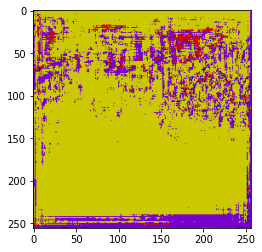


Val loss:    4.9386



Train loss:    4.9386



Val loss:    3.1643



Train loss:    3.1643



Val loss:    2.9394



Train loss:    2.9394


[[1 1 1 ... 2 2 4]
 [1 2 4 ... 1 1 4]
 [1 1 2 ... 2 2 4]
 ...
 [1 1 1 ... 0 4 4]
 [1 4 4 ... 0 4 4]
 [1 4 4 ... 0 4 4]]


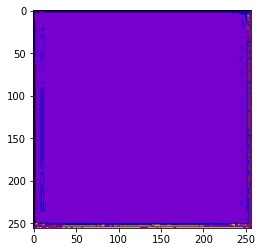


Val loss:    2.2475



Train loss:    2.2475



Val loss:    4.0455



Train loss:    4.0455



Val loss:    1.4141



Train loss:    1.4141



Val loss:    1.7790



Train loss:    1.7790


[[1 2 2 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 [1 1 1 ... 2 2 4]
 ...
 [1 1 4 ... 1 4 4]
 [1 4 4 ... 4 4 4]
 [1 3 4 ... 4 4 4]]


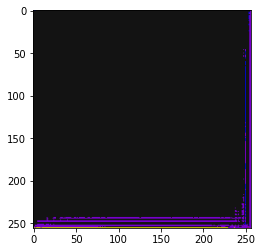


Val loss:    2.4080



Train loss:    2.4080


[[1 2 1 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 [1 1 1 ... 2 4 4]
 ...
 [1 1 4 ... 4 4 4]
 [1 4 4 ... 4 4 4]
 [1 3 4 ... 4 4 4]]


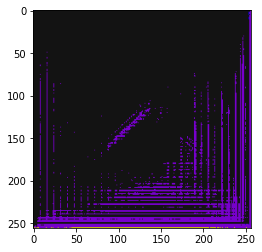


Val loss:    1.8283



Train loss:    1.8283


[[1 2 1 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 [1 1 1 ... 2 4 4]
 ...
 [1 1 4 ... 4 4 4]
 [1 4 4 ... 4 4 4]
 [1 4 4 ... 4 4 4]]


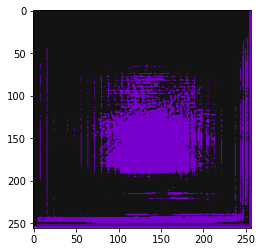


Val loss:    1.6144



In [ ]:

loss_train = []
loss_val = []
for epoch in tqdm(range(epochs),'Epoch'):
  epoch_loss_train = 0
  # train
  tqdm_loop = tqdm(enumerate(train_loader), 'Steps', total=len(train_loader))
  for i, data in tqdm_loop:
    img = data['image'].to(device, dtype=torch.float32)
    mask =data['mask'].to(device, dtype=torch.long)

    predicted_mask = model(img)
    loss = criterion(predicted_mask, mask)

    loss.backward()
    optimizer.step()

    epoch_loss_train += loss.item()
    epoch_loss = epoch_loss_train/ len(train_loader)
    loss_train.append(epoch_loss)
  print(f'Train loss: {epoch_loss:9.4f}')

  # val
  with torch.no_grad():
    epoch_loss_val = 0
    best_val_loss = 0
    model.eval()
    tqdm_loop = tqdm(enumerate(val_loader), 'Steps', total=len(val_loader))
    for i, data in tqdm_loop:
      img = data['image'].to(device, dtype=torch.float32)
      mask =data['mask'].to(device, dtype=torch.long)

      predicted_mask = model(img)
      loss = criterion(predicted_mask, mask)


      epoch_loss_val += loss.item()
      epoch_loss = epoch_loss_val/ len(val_loader)
      loss_val.append(epoch_loss)

      if i == randint(0,len(val_loader)):        
        mask = predicted_mask.argmax(1)[0].cpu().detach().numpy() 
        print(mask)  
        rgb = decode_seqmap(mask)            
        plt.imshow(rgb);plt.show()
        #TODO visualize mask
        #TODO add plots for metrics
        #TODO add test on images from web or video
        #TODO add metrics and losses IOU and DICE loss
        

      if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        model.save()
        print('Checkpoints are saved!')

    print(f'Val loss: {epoch_loss:9.4f}')







                         
  

---Train loss---


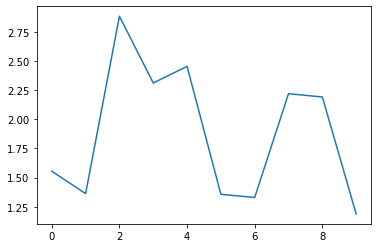

In [ ]:
print('---Train loss---')
plt.plot(range(epochs), loss_train)


---Validation loss---


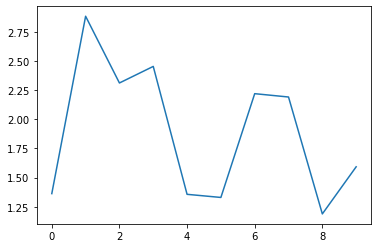

In [ ]:
print('---Validation loss---')
plt.plot(range(epochs), loss_val)

In [ ]:
from PIL import Image
import tensorflow as tf


In [ ]:
def segment(model, path):
  image = Image.open(path)
  plt.imshow(image); plt.axis('off'); plt.show()
  transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((image_size,image_size))])
  norm_img = transforms.Normalize((0.485,0.456,0.406),(0.229, 0.224, 0.225))
  image = norm_img(transform(image))
  pr_mask = model((image.unsqueeze(0)).to(device, dtype=torch.float32))
  mask = pr_mask.argmax(1)[0].cpu().detach().numpy() 
  print(mask)  
  rgb = decode_seqmap(mask)            
  plt.imshow(rgb);plt.show()

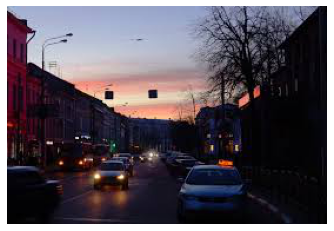

[[1 2 2 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 [1 1 1 ... 2 4 4]
 ...
 [1 1 4 ... 1 4 4]
 [1 4 4 ... 4 4 4]
 [1 3 3 ... 4 4 4]]


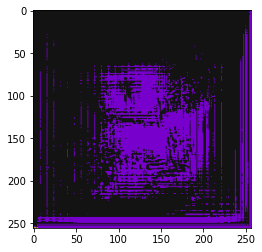

In [ ]:
segment(model, './images.jpg')

# Note

```transforms.Normalize((0.485,0.456,0.406),(0229, 0.224.0.225)) ```

``` 
      mask[mask < 0.255] = 4.0
      mask[mask < 0.35] = 3.0
      mask[mask < 0.443] = 2.0
      mask[mask < 0.54] = 1.0
      mask[mask < 0.7] = 0.0
```                                

In [ ]:
!pip install pytube

     |████████████████████████████████| 61kB 6.7MB/s 


# Snippets for video

In [ ]:
# Download video from youtube
from pytube import YouTube
import shutil
video = YouTube('https://www.youtube.com/watch?v=vRkZSawiMGU')
video.streams.filter(file_extension = "mp4").all()
path = video.streams.get_by_itag(18).download()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  """


In [ ]:
# Extract frames https://stackoverflow.com/a/63686021/9875025
!mkdir frames
import cv2
import os

KPS = 0.1 # per second capture rate
VIDEO_PATH = path #"path/to/video/folder" 
OUT_FRAMES_PATH = "frames/"
EXTENSION = ".png"

cap = cv2.VideoCapture(VIDEO_PATH)
fps = round(cap.get(cv2.CAP_PROP_FPS))

print(fps)


step = round(fps / KPS)
curr_frame = 0
while(True):
    ret, frame = cap.read()
    if not ret: break
    if curr_frame % step == 0:
            name = OUT_FRAMES_PATH + "_" + str(curr_frame) + EXTENSION
            cv2.imwrite(name, frame)
    curr_frame += 1
cap.release()



print("number of frames: ", len(os.listdir("/content/frames")))

25
number of frames:  67
